# Modeling Heat Dispersion

In this notebook we will be looking modeling how heat travels on the plane. **REALLY** we will be looking at how we can construct the same model in different ways to acheive **FASTER** results.

In [31]:
#Set the size of our plane and the error.

N = 101
epsilon = 0.2

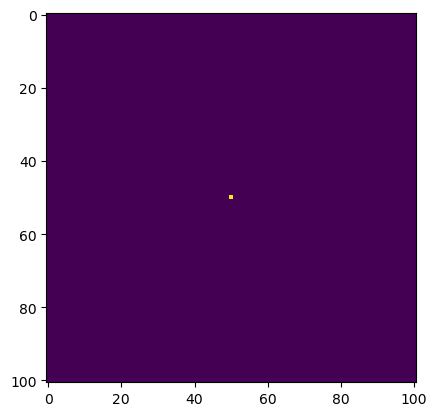

In [33]:
import numpy as np
from matplotlib import pyplot as plt
# construct initial condition: 1 unit of heat at midpoint. 
u0 = np.zeros((N, N))
u0[int(N/2), int(N/2)] = 1.0
plt.imshow(u0)

## Initial Simulations

In these first simulations, matrix multiplication will be used to change the state of the simulation to reflect how the heat travels through the plane. u0 will represent the plane in it's initial state and A will be the update matrix.

In [36]:
def advance_time_matvecmul(A, u, epsilon):
    """Advances the simulation by one timestep, via matrix-vector multiplication
    Args:
        A: The 2d finite difference matrix, N^2 x N^2. 
        u: N x N grid state at timestep k.
        epsilon: stability constant.

    Returns:
        N x N Grid state at timestep k+1.
    """
    N = u.shape[0]
    u = u + epsilon * (A @ u.flatten()).reshape((N, N))
    return u

In [38]:
def get_A(N):
    """Generates the update matrix"""
    n = N * N
    diagonals = [-4 * np.ones(n), np.ones(n-1), np.ones(n-1), np.ones(n-N), np.ones(n-N)]
    diagonals[1][(N-1)::N] = 0
    diagonals[2][(N-1)::N] = 0
    A = np.diag(diagonals[0]) + np.diag(diagonals[1], 1) + np.diag(diagonals[2], -1) + np.diag(diagonals[3], N) + np.diag(diagonals[4], -N)
    return A

In [40]:
def simulation1(num_iterations, u, A, epsilson):
    """Simulates heat flow"""
    for i in range(num_iterations):
        u = advance_time_matvecmul(A, u, epsilon)
        if i%300 == 0:
            plt.imshow(u)

In [42]:
A = get_A(N)

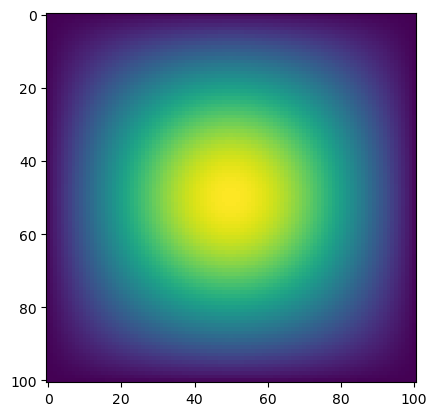

In [43]:
simulation1(2700, u0, A, epsilon)

### Very Slow...

This took about 7 minutes to run. We can speed it up using a sparse encoding of our update matrix from jax.

In [45]:
from jax.experimental import sparse
import jax.numpy as jnp
from jax import jit

In [46]:
def get_sparse_A(N):
    """Genereates sparse matrix"""
    n = N * N
    diagonals = [-4 * jnp.ones(n), jnp.ones(n-1), jnp.ones(n-1), jnp.ones(n-N), jnp.ones(n-N)]
    diagonals[1] = diagonals[1].at[(N-1)::N].set(0)
    diagonals[2] = diagonals[2].at[(N-1)::N].set(0)
    A = jnp.diag(diagonals[0]) + jnp.diag(diagonals[1], 1) + jnp.diag(diagonals[2], -1) + jnp.diag(diagonals[3], N) + jnp.diag(diagonals[4], -N)
    A = sparse.BCOO.fromdense(A)
    return A

In [47]:
A_sparse = get_sparse_A(N)

In [48]:
u0 = jnp.zeros((N, N))
u0 = u0.at[int(N/2), int(N/2)].set(1.0)


In [59]:
def simulation2(num_iterations, u, A, epsilson):
    for i in range(num_iterations):
        u = advance_time_matvecmul(A, u, epsilon)
        if i%300 == 0:
            plt.imshow(u)

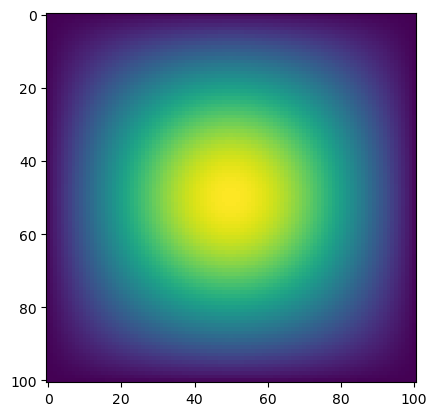

In [63]:
simulation2(2700, u0, A_sparse, epsilon)

### Compare Times

comparing the times, we see the sparse encoding helps a lot.

time: 324.012654 seconds


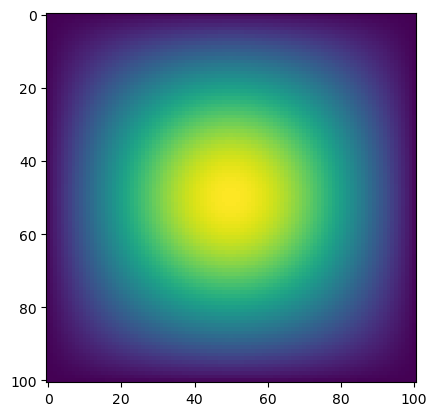

In [65]:
import timeit
"""get execution time"""
time_taken1 = timeit.timeit(lambda: simulation1(2700, u0, A, epsilon), number=1)
print(f"time: {time_taken1:.6f} seconds")

time: 7.834111 seconds


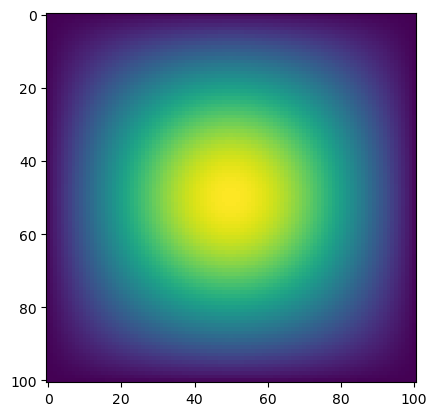

In [66]:
time_taken2 = timeit.timeit(lambda: simulation2(2700, u0, A_sparse, epsilon), number=1)
print(f"time: {time_taken2:.6f} seconds")

## Numpy Implemenation(No Matrix Multiply)

Now we try a numpy implementation of our simulation using np.roll to remove the need for expensive matrix multiplication when updating.

In [68]:
def advance_time_numpy(u, epsilon):
    return u + epsilon *  (np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) + np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) - 4 * u)

In [69]:
def simulation3(num_iterations, u, epsilson):
    for i in range(num_iterations):
        u = advance_time_numpy(u, epsilon)
        if i%300 == 0:
            plt.imshow(u)

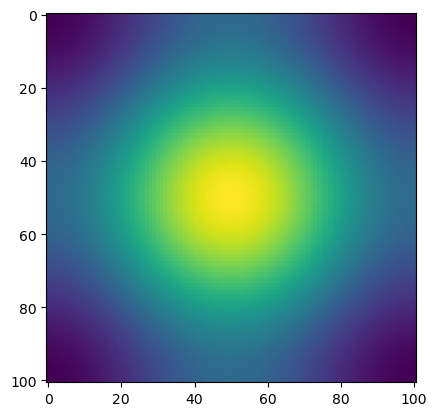

In [70]:
simulation3(2700,u0,epsilon)

time: 0.505210 seconds


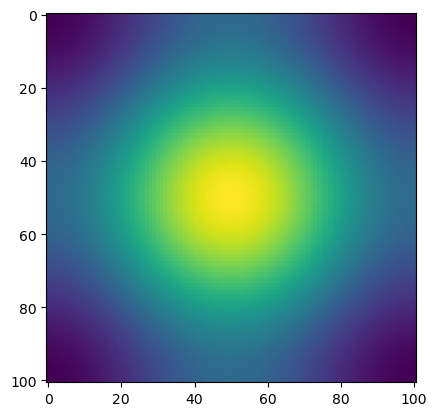

In [71]:
time_taken3 = timeit.timeit(lambda: simulation3(2700, u0, epsilon), number=1)
print(f"time: {time_taken3:.6f} seconds")

Finally we implement the previous simulation using JAX.

In [87]:
from jax import jit
@jit
def advance_time_jax(u, epsilon):
    return u + epsilon *  (jnp.roll(u, 1, axis=0) + jnp.roll(u, -1, axis=0) + jnp.roll(u, 1, axis=1) + jnp.roll(u, -1, axis=1) - 4 * u)

In [89]:
def simulation4(num_iterations, u, epsilson):
    for i in range(num_iterations):
        
        u = advance_time_jax(u, epsilon)
        if i%300 == 0:
            plt.imshow(u)

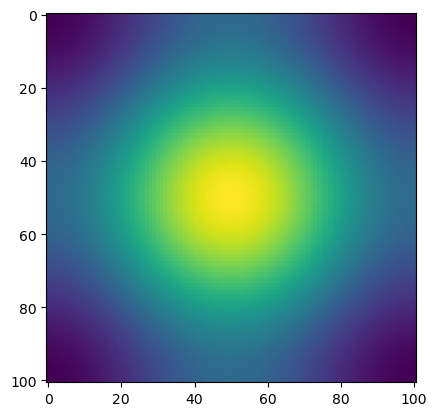

In [91]:
simulation4(2700,u0,epsilon)

time: 0.070264 seconds


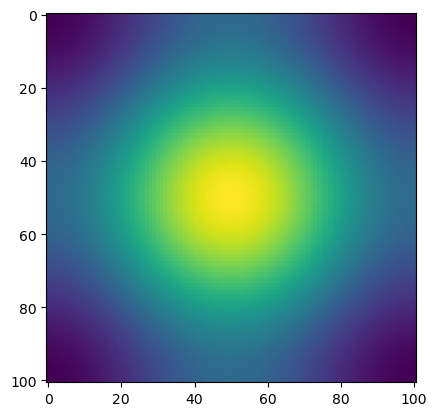

In [93]:
time_taken4 = timeit.timeit(lambda: simulation4(2700, u0, epsilon), number=1)
print(f"time: {time_taken4:.6f} seconds")

## Analysis of time data

In [96]:
time_data = {"advance_time_matvecmul":time_taken1,"advance_time_matvecmul(sparse)":time_taken2,"advance_time_numpy":time_taken3,"advance_time_jnp":time_taken4}

In [98]:
time_data

{'advance_time_matvecmul': 324.0126543333754,
 'advance_time_matvecmul(sparse)': 7.834111416712403,
 'advance_time_numpy': 0.505210374481976,
 'advance_time_jnp': 0.07026433479040861}

In [100]:
import pandas as pd
times = pd.DataFrame(time_data, index=["Times"])

In [102]:
times

,advance_time_matvecmul,advance_time_matvecmul(sparse),advance_time_numpy,advance_time_jnp
Times,324.012654,7.834111,0.50521,0.070264


Text(0.5, 1.0, 'Computation Times')

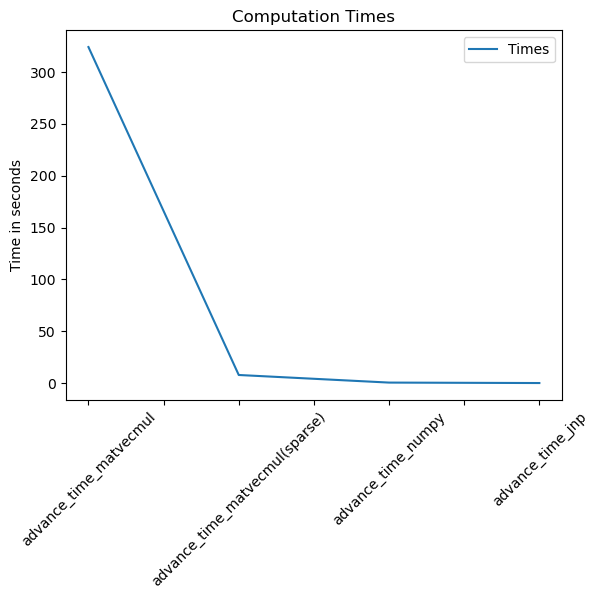

In [104]:
times.T.plot()
plt.xticks(rotation = 45)
plt.ylabel("Time in seconds")
plt.title("Computation Times")

Text(0.5, 1.0, 'Log of Computation Times')

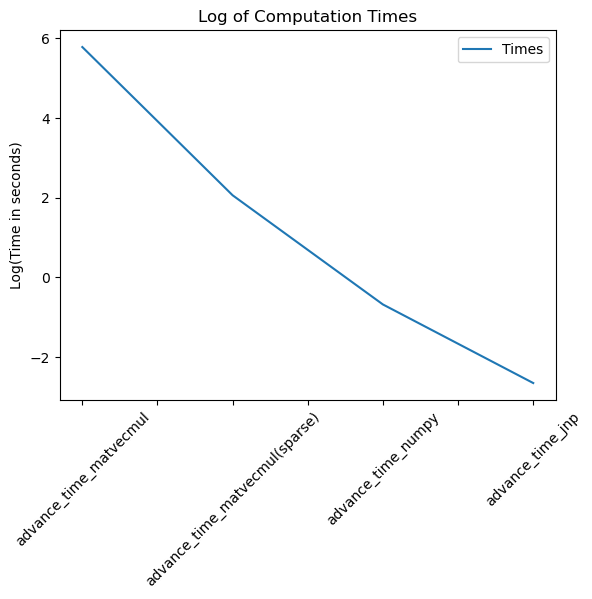

In [106]:
np.log(times.T).plot()
plt.xticks(rotation = 45)
plt.ylabel("Log(Time in seconds)")
plt.title("Log of Computation Times")

## Conclusion

From the "Log of Computation Times" graph, it is clear that time taken to execute the simulation is reduced by a factor of ten for each optimization. At the end, the improvements start to taper off, but this was expected. Overall, heat dispersion simulations can be done very quickly in this setting, but if you make the wrong design choices, you could be waiting around for a while.